In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip3 install tokenizers wandb sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 13.4 MB/s 
     |████████████████████████████████| 1.8 MB 68.1 MB/s 
     |████████████████████████████████| 1.3 MB 75.9 MB/s 
     |████████████████████████████████| 181 kB 100.7 MB/s 
     |████████████████████████████████| 157 kB 85.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 157 kB 96.4 MB/s 
     |████████████████████████████████| 156 kB 86.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=413c22f8b4b037a6c772bb0d8f6de47d7876605562a43c9698bfe954cf07a2b1
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [3]:
!pip3 install transformers huggingface-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 15.9 MB/s 
     |████████████████████████████████| 101 kB 14.0 MB/s 
     |████████████████████████████████| 596 kB 92.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
!pip3 install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 14.4 MB/s 
     |████████████████████████████████| 115 kB 94.9 MB/s 
     |████████████████████████████████| 141 kB 101.5 MB/s 
     |████████████████████████████████| 212 kB 104.3 MB/s 
     |████████████████████████████████| 127 kB 100.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [5]:
!pip3 install bertviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 15.1 MB/s 
     |████████████████████████████████| 132 kB 93.3 MB/s 
     |████████████████████████████████| 9.0 MB 99.7 MB/s 
     |████████████████████████████████| 79 kB 10.5 MB/s 


In [6]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Research')

In [7]:
OUTPUT_DIR = './transformer-anatomy-outputs/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug  7 11:22:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# CFG

In [9]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='bluehills'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="transformersbook/bert-base-uncased-finetuned-clinc"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=50 # [0, 50, 100]
    epochs=5
    encoder_lr=1e-5 #2e-5
    decoder_lr=1e-5 #2e-5
    min_lr=5e-7
    eps=5e-7
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.15
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=44
    train_all_index=20
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [10]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb
    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        # wandb.login(key=secret_value_0)
        print('login to wandb')
        wandb.login()
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='Model-Compression-Test', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

login to wandb


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bluehills. Use `wandb login --relogin` to force relogin


# Library

In [11]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
from math import sqrt
import shutil
import string
import pickle
import random
import joblib
import itertools
import logging
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.cuda.amp as amp

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification, AutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import TrainingArguments, Trainer

import datasets
import huggingface_hub
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.12.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.21.1
env: TOKENIZERS_PARALLELISM=true


# Utils

In [12]:
# ====================================================
# Utils
# ====================================================

def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=CFG.seed)

# Making Transformers Efficient in Production

In [13]:
#hide_output
from transformers import pipeline

bert_ckpt = CFG.model
pipe = pipeline("text-classification", model=bert_ckpt)

In [14]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.549003541469574}]

## Creating a Performance Benchmark

In [15]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        # We'll define this later
        pass    

    def compute_size(self):
        # We'll define this later
        pass

    def time_pipeline(self):
        # We'll define this later
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [16]:
#hide_output
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
sample = clinc["test"][42]
sample

{'intent': 133, 'text': 'transfer $100 from my checking to saving account'}

In [18]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [19]:
#hide_output
from datasets import load_metric 

accuracy_score = load_metric("accuracy")

In [20]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [21]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [22]:
def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [23]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 45.421
Latency (ms) - 50.869
Latency (ms) - 45.907


In [24]:
def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [25]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.16
Average latency (ms) - 32.56 +\- 1.66
Accuracy on test set - 0.867


# Making Models Smaller via Knowledge Distillation

## Knowledge Distillation for Pretraining

In [26]:
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature


class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

## Choosing a Good Student Initialization

In [27]:
#hide_output
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [28]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)


batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch", 
    num_train_epochs=5, learning_rate=2e-5, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01, 
    push_to_hub=False)

In [29]:
#hide
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
student_training_args.log_level = 40

In [30]:
#hide
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [31]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id


num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels, 
                                   id2label=id2label, label2id=label2id))

In [32]:
def student_init():
    return (AutoModelForSequenceClassification.from_pretrained(student_ckpt, config=student_config).to(device))

In [33]:
#hide_output
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [34]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,4.289200,3.283044,0.743226
2,2.627000,1.872838,0.840323
3,1.542900,1.155412,0.890968
4,1.008900,0.852967,0.912903
5,0.793800,0.771037,0.917742


TrainOutput(global_step=1590, training_loss=2.048446711054388, metrics={'train_runtime': 180.0738, 'train_samples_per_second': 423.438, 'train_steps_per_second': 8.83, 'total_flos': 413896353421488.0, 'train_loss': 2.048446711054388, 'epoch': 5.0})

In [35]:
#hide_output
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.89
Average latency (ms) - 16.46 +\- 0.61
Accuracy on test set - 0.858


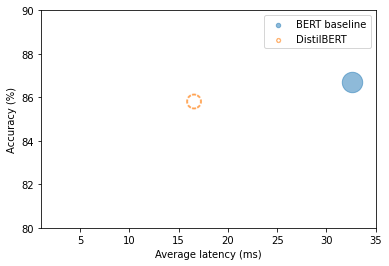

In [36]:
def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
    
plot_metrics(perf_metrics, optim_type)

# Finding Good Hyperparameters with Optuna

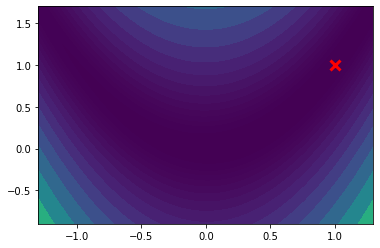

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2
    
X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [38]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2


In [39]:
!pip3 install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 14.8 MB/s 
     |████████████████████████████████| 81 kB 10.6 MB/s 
     |████████████████████████████████| 209 kB 80.4 MB/s 
     |████████████████████████████████| 78 kB 9.9 MB/s 
     |████████████████████████████████| 112 kB 106.2 MB/s 
     |████████████████████████████████| 147 kB 99.7 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=cc8090afe1670a30b631f5dae322c15ba9fbf3c869a9d91317c34bcb6a4138cd
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [40]:
#hide_output
import optuna 

study = optuna.create_study()
study.optimize(objective, n_trials=1000)
study.best_params

[I 2022-08-07 11:31:11,064] A new study created in memory with name: no-name-42776887-48dd-4508-9756-309342493ff5
[I 2022-08-07 11:31:11,068] Trial 0 finished with value: 852.898832742143 and parameters: {'x': 1.313843913118074, 'y': -1.1940887048453117}. Best is trial 0 with value: 852.898832742143.
[I 2022-08-07 11:31:11,070] Trial 1 finished with value: 104.20748928357843 and parameters: {'x': 0.5325803033279133, 'y': 1.3033917886163695}. Best is trial 1 with value: 104.20748928357843.
[I 2022-08-07 11:31:11,072] Trial 2 finished with value: 1122.9822246871524 and parameters: {'x': 1.5156279544083784, 'y': -1.0535678800270634}. Best is trial 1 with value: 104.20748928357843.
[I 2022-08-07 11:31:11,075] Trial 3 finished with value: 385.82360017231287 and parameters: {'x': -0.4008450596039692, 'y': -1.798560929976587}. Best is trial 1 with value: 104.20748928357843.
[I 2022-08-07 11:31:11,077] Trial 4 finished with value: 73.56553885139573 and parameters: {'x': 1.5725125967040081, 'y'

{'x': 1.0036054867005806, 'y': 1.0089987168003693}

In [41]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [42]:
#hide_output
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)
print(best_run)

[I 2022-08-07 11:31:24,073] A new study created in memory with name: no-name-c27145cc-e7b5-4121-a6bd-e34325e07d14


eval/accuracy,▁▅▇██
eval/loss,█▄▂▁▁
eval/runtime,▄▁▇█▁
eval/samples_per_second,▆█▂▁█
eval/steps_per_second,▅█▂▁█
train/epoch,▁▁▃▃▄▅▆▆███
train/global_step,▁▁▃▃▄▅▆▆███
train/learning_rate,█▆▅▃▁
train/loss,█▅▃▁▁
train/total_flos,▁
train/train_loss,▁


Epoch,Training Loss,Validation Loss,Accuracy
1,0.385100,0.196748,0.588387
2,0.163600,0.094091,0.839355
3,0.100700,0.063244,0.886774
4,0.075200,0.047353,0.906129
5,0.061800,0.038901,0.917742
6,0.053700,0.034222,0.921613
7,0.048500,0.031434,0.924516
8,0.045200,0.029287,0.923548
9,0.043200,0.028064,0.924516
10,0.041900,0.027642,0.925161


[I 2022-08-07 11:37:29,906] Trial 0 finished with value: 0.9251612903225807 and parameters: {'num_train_epochs': 10, 'alpha': 0.2201543342929777, 'temperature': 17}. Best is trial 0 with value: 0.9251612903225807.


eval/accuracy,▁▆▇███████
eval/loss,█▄▂▂▁▁▁▁▁▁
eval/runtime,█▄▁▁▂▂▃▄▂▁
eval/samples_per_second,▁▅██▇▇▆▅▇█
eval/steps_per_second,▁▅██▇▇▆▅▇█
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▃▂▂▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Epoch,Training Loss,Validation Loss,Accuracy
1,0.441000,0.229344,0.606774
2,0.190000,0.108619,0.829677
3,0.115900,0.072012,0.884516
4,0.087000,0.054426,0.905484
5,0.072800,0.045973,0.912903
6,0.065100,0.041959,0.916452
7,0.061300,0.040528,0.917097


[I 2022-08-07 11:41:48,368] Trial 1 finished with value: 0.9170967741935484 and parameters: {'num_train_epochs': 7, 'alpha': 0.8267491351566262, 'temperature': 6}. Best is trial 0 with value: 0.9251612903225807.


eval/accuracy,▁▆▇████
eval/loss,█▄▂▂▁▁▁
eval/runtime,▁▂▁▁▁█▄
eval/samples_per_second,█▇███▁▅
eval/steps_per_second,█▇███▁▅
train/epoch,▁▁▂▂▃▃▄▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▅▆▆▇▇███
train/learning_rate,█▇▆▅▃▂▁
train/loss,█▃▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Epoch,Training Loss,Validation Loss,Accuracy
1,0.808400,0.425323,0.653226
2,0.331100,0.162657,0.836774
3,0.163600,0.088472,0.889355
4,0.108800,0.063506,0.908387
5,0.088500,0.054711,0.914194
6,0.080300,0.052427,0.915806


[I 2022-08-07 11:45:30,497] Trial 2 finished with value: 0.9158064516129032 and parameters: {'num_train_epochs': 6, 'alpha': 0.8034803037427857, 'temperature': 2}. Best is trial 0 with value: 0.9251612903225807.


eval/accuracy,▁▆▇███
eval/loss,█▃▂▁▁▁
eval/runtime,▁▂▃█▅▇
eval/samples_per_second,█▇▆▁▄▂
eval/steps_per_second,█▇▆▁▄▂
train/epoch,▁▁▂▂▄▄▅▅▇▇███
train/global_step,▁▁▂▂▄▄▅▅▇▇███
train/learning_rate,█▇▅▄▂▁
train/loss,█▃▂▁▁▁
train/total_flos,▁
train/train_loss,▁


Epoch,Training Loss,Validation Loss,Accuracy
1,0.440100,0.227216,0.610645
2,0.187500,0.105949,0.836452
3,0.113000,0.069280,0.888387
4,0.083600,0.051416,0.907097
5,0.068900,0.042543,0.916452
6,0.060600,0.037896,0.919032
7,0.055600,0.035476,0.921935
8,0.053300,0.034549,0.919677


[I 2022-08-07 11:50:24,040] Trial 3 finished with value: 0.9196774193548387 and parameters: {'num_train_epochs': 8, 'alpha': 0.7890396500910609, 'temperature': 6}. Best is trial 0 with value: 0.9251612903225807.


eval/accuracy,▁▆▇█████
eval/loss,█▄▂▂▁▁▁▁
eval/runtime,▂▃▃▂▂▂█▁
eval/samples_per_second,▇▆▆▇▇▇▁█
eval/steps_per_second,▇▆▆▇▇▇▁█
train/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇███
train/learning_rate,█▇▆▅▄▃▂▁
train/loss,█▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Epoch,Training Loss,Validation Loss,Accuracy
1,0.417900,0.217252,0.597419
2,0.180900,0.104846,0.830000
3,0.112100,0.070852,0.884516
4,0.085000,0.054215,0.903226
5,0.071600,0.046031,0.911290
6,0.064300,0.042112,0.917097
7,0.060600,0.040712,0.916774


[I 2022-08-07 11:54:42,261] Trial 4 finished with value: 0.9167741935483871 and parameters: {'num_train_epochs': 7, 'alpha': 0.5537742425943469, 'temperature': 8}. Best is trial 0 with value: 0.9251612903225807.


eval/accuracy,▁▆▇████
eval/loss,█▄▂▂▁▁▁
eval/runtime,▆▄▆▁▂█▄
eval/samples_per_second,▃▅▃█▇▁▅
eval/steps_per_second,▃▅▃█▇▁▅
train/epoch,▁▁▂▂▃▃▄▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▅▆▆▇▇███
train/learning_rate,█▇▆▅▃▂▁
train/loss,█▃▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Epoch,Training Loss,Validation Loss,Accuracy
1,0.802700,0.411362,0.660323
2,0.312200,0.143489,0.850968
3,0.143900,0.074973,0.899355
4,0.091900,0.052016,0.914839
5,0.072100,0.043242,0.920000
6,0.062100,0.038940,0.926774
7,0.056300,0.036394,0.928065
8,0.052900,0.034839,0.927742
9,0.051400,0.034324,0.928387


[I 2022-08-07 12:00:12,101] Trial 5 finished with value: 0.9283870967741935 and parameters: {'num_train_epochs': 9, 'alpha': 0.9581916565487288, 'temperature': 2}. Best is trial 5 with value: 0.9283870967741935.


eval/accuracy,▁▆▇██████
eval/loss,█▃▂▁▁▁▁▁▁
eval/runtime,█▂█▂▅▂▆▁▇
eval/samples_per_second,▁▇▁▇▄▇▃█▂
eval/steps_per_second,▁▇▁▇▄▇▃█▂
train/epoch,▁▁▂▂▃▃▄▄▄▅▅▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▄▅▅▅▆▆▇▇███
train/learning_rate,█▇▆▅▅▄▃▂▁
train/loss,█▃▂▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Epoch,Training Loss,Validation Loss,Accuracy
1,0.497200,0.254096,0.635161
2,0.205100,0.109574,0.850323
3,0.116000,0.066992,0.896452
4,0.082000,0.047512,0.913226
5,0.065500,0.038232,0.918710
6,0.056300,0.033564,0.925161
7,0.050500,0.030836,0.926774
8,0.047000,0.028787,0.927742
9,0.044900,0.027595,0.926452
10,0.043400,0.027205,0.925806


[I 2022-08-07 12:06:17,907] Trial 6 finished with value: 0.9258064516129032 and parameters: {'num_train_epochs': 10, 'alpha': 0.14838204342632189, 'temperature': 4}. Best is trial 5 with value: 0.9283870967741935.


eval/accuracy,▁▆▇███████
eval/loss,█▄▂▂▁▁▁▁▁▁
eval/runtime,▆█▁▆▆▆▁▃▇▂
eval/samples_per_second,▃▁█▃▃▃█▆▂▇
eval/steps_per_second,▃▁█▃▃▃█▆▂▇
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▃▂▂▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Epoch,Training Loss,Validation Loss,Accuracy
1,0.386800,0.197476,0.592903


[I 2022-08-07 12:07:03,750] Trial 7 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁█
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.5929
eval/loss,0.19748


Epoch,Training Loss,Validation Loss,Accuracy
1,0.383700,0.197890,0.578387


[I 2022-08-07 12:07:49,509] Trial 8 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁█
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.57839
eval/loss,0.19789


Epoch,Training Loss,Validation Loss,Accuracy
1,0.389700,0.206733,0.560968


[I 2022-08-07 12:08:34,998] Trial 9 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁█
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.56097
eval/loss,0.20673


Epoch,Training Loss,Validation Loss,Accuracy
1,0.396300,0.203411,0.594194


[I 2022-08-07 12:09:20,910] Trial 10 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁█
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.59419
eval/loss,0.20341


Epoch,Training Loss,Validation Loss,Accuracy
1,0.802700,0.411362,0.660323
2,0.312200,0.143489,0.850968
3,0.143900,0.074973,0.899355
4,0.091900,0.052016,0.914839
5,0.072100,0.043242,0.920000
6,0.062100,0.038940,0.926774
7,0.056300,0.036394,0.928065
8,0.052900,0.034839,0.927742
9,0.051400,0.034324,0.928387


[I 2022-08-07 12:14:51,266] Trial 11 finished with value: 0.9283870967741935 and parameters: {'num_train_epochs': 9, 'alpha': 0.018764248326142402, 'temperature': 2}. Best is trial 5 with value: 0.9283870967741935.


eval/accuracy,▁▆▇██████
eval/loss,█▃▂▁▁▁▁▁▁
eval/runtime,█▂▄▃▃▁▃▂▁
eval/samples_per_second,▁▇▅▆▆█▆▇█
eval/steps_per_second,▁▇▅▆▆█▆▇█
train/epoch,▁▁▂▂▃▃▄▄▄▅▅▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▄▅▅▅▆▆▇▇███
train/learning_rate,█▇▆▅▅▄▃▂▁
train/loss,█▃▂▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Epoch,Training Loss,Validation Loss,Accuracy
1,0.802700,0.411362,0.660323
2,0.312200,0.143489,0.850968
3,0.143900,0.074973,0.899355
4,0.091900,0.052016,0.914839
5,0.072100,0.043242,0.920000
6,0.062100,0.038940,0.926774
7,0.056300,0.036394,0.928065
8,0.052900,0.034839,0.927742
9,0.051400,0.034324,0.928387


[I 2022-08-07 12:20:21,798] Trial 12 finished with value: 0.9283870967741935 and parameters: {'num_train_epochs': 9, 'alpha': 0.017884656933619188, 'temperature': 2}. Best is trial 5 with value: 0.9283870967741935.


eval/accuracy,▁▆▇██████
eval/loss,█▃▂▁▁▁▁▁▁
eval/runtime,▁▅▆▄▃▄▃▄█
eval/samples_per_second,█▄▃▅▆▅▆▅▁
eval/steps_per_second,█▄▃▅▆▅▆▅▁
train/epoch,▁▁▂▂▃▃▄▄▄▅▅▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▄▅▅▅▆▆▇▇███
train/learning_rate,█▇▆▅▅▄▃▂▁
train/loss,█▃▂▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Epoch,Training Loss,Validation Loss,Accuracy
1,0.399800,0.205199,0.596452


[I 2022-08-07 12:21:08,351] Trial 13 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁█
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.59645
eval/loss,0.2052


Epoch,Training Loss,Validation Loss,Accuracy
1,0.409400,0.210089,0.601613


[I 2022-08-07 12:21:54,507] Trial 14 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁█
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.60161
eval/loss,0.21009


Epoch,Training Loss,Validation Loss,Accuracy
1,0.498700,0.257825,0.627742


[I 2022-08-07 12:22:40,390] Trial 15 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁█
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.62774
eval/loss,0.25782


Epoch,Training Loss,Validation Loss,Accuracy
1,0.460800,0.236680,0.621613


[I 2022-08-07 12:23:26,300] Trial 16 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁█
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.62161
eval/loss,0.23668


Epoch,Training Loss,Validation Loss,Accuracy
1,0.804000,0.414670,0.658387
2,0.316700,0.147940,0.845806
3,0.148300,0.077788,0.897419
4,0.095400,0.054247,0.914194
5,0.075300,0.045369,0.918387
6,0.065400,0.041108,0.925806
7,0.060000,0.038727,0.925484
8,0.057300,0.037987,0.924194


[I 2022-08-07 12:28:22,019] Trial 17 pruned. 


eval/accuracy,▁▆▇█████
eval/loss,█▃▂▁▁▁▁▁
eval/runtime,▃▃▁▅█▂▆█
eval/samples_per_second,▆▆█▄▁▇▃▁
eval/steps_per_second,▆▆█▄▁▇▃▁
train/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/learning_rate,█▇▆▅▄▃▂▁
train/loss,█▃▂▁▁▁▁▁
eval/accuracy,0.92419
eval/loss,0.03799


Epoch,Training Loss,Validation Loss,Accuracy
1,0.390700,0.199449,0.593226


[I 2022-08-07 12:29:08,527] Trial 18 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁█
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.59323
eval/loss,0.19945


Epoch,Training Loss,Validation Loss,Accuracy
1,0.419100,0.219721,0.590645


[I 2022-08-07 12:29:54,481] Trial 19 pruned. 


BestRun(run_id='5', objective=0.9283870967741935, hyperparameters={'num_train_epochs': 9, 'alpha': 0.9581916565487288, 'temperature': 2})


In [43]:
#hide_output
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)
    
# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
1,4.120300,3.082678,0.752258
2,2.363400,1.553813,0.862903
3,1.171100,0.795330,0.909032
4,0.595200,0.486337,0.932903
5,0.342600,0.372711,0.939355
6,0.228300,0.327336,0.942258
7,0.173100,0.305059,0.944194
8,0.145500,0.300114,0.945161
9,0.135700,0.298090,0.946129


In [45]:
#hide_output
# distil_trainer.push_to_hub("Training complete")

# Benchmarking Our Distilled Model

In [46]:
distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.89
Average latency (ms) - 19.06 +\- 4.23
Accuracy on test set - 0.868


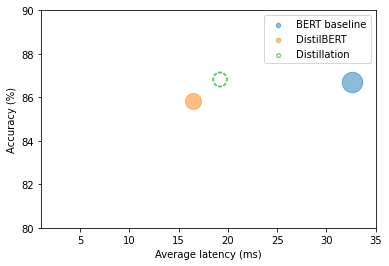

In [47]:
plot_metrics(perf_metrics, optim_type)

# Making Models Faster with Quantization

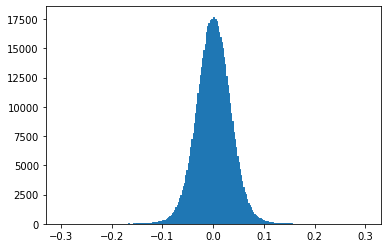

In [48]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [49]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [50]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

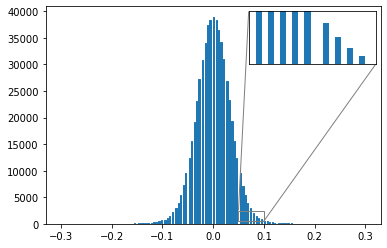

In [51]:
#hide_input
#id weight-quantization
#alt Effect of quantization on a transformer's weights
#caption Effect of quantization on a transformer's weights
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# Create histogram
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# Create zoom inset
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [52]:
%%timeit 
weights @ weights

The slowest run took 5.33 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 2.3 ms per loop


In [53]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [54]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

The slowest run took 7.91 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 117 µs per loop


In [55]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

3.9996745144841053

In [56]:
#hide_output
from torch.quantization import quantize_dynamic

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)


In [57]:
#hide_output
from torch.quantization import quantize_dynamic

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

# Benchmarking our quantized model

In [58]:
pipe = pipeline("text-classification", model=model_quantized, 
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.40
Average latency (ms) - 19.48 +\- 1.14
Accuracy on test set - 0.876


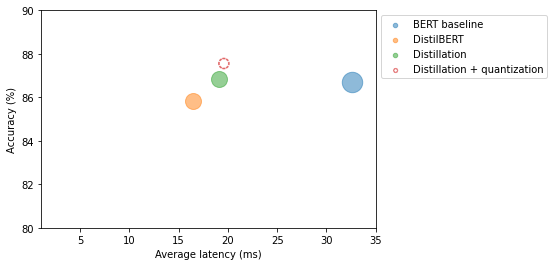

In [59]:
plot_metrics(perf_metrics, optim_type)

# Optimizing Inference with ONNX and the ONNX Runtime

In [60]:
#hide_output
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [61]:
#hide_output
from transformers.convert_graph_to_onnx import convert

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, 
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

ONNX opset version set to: 12
Loading pipeline (model: transformersbook/distilbert-base-uncased-distilled-clinc, tokenizer: PreTrainedTokenizerFast(name_or_path='transformersbook/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))
Creating folder onnx
Using framework PyTorch: 1.12.0+cu113
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


In [74]:
!pip3 install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, 
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"): 
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [64]:
onnx_model = create_model_for_provider(onnx_model_path)

inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [65]:
np.argmax(logits_onnx)

61

In [66]:
clinc_enc["test"][0]["labels"]

61

In [67]:
from scipy.special import softmax


class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy() 
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]\


class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
        
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}


pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.7848334}]

In [68]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.90
Average latency (ms) - 19.49 +\- 0.68
Accuracy on test set - 0.868


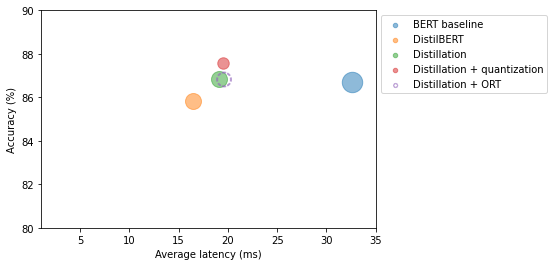

In [69]:
plot_metrics(perf_metrics, optim_type)

In [71]:
!pip3 install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 14.8 MB/s 


In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType


model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)

optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, 
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

# Making model sparser with weight pruning

## Magnitude pruning

In [ ]:
#hide_input
#id sparsity-scheduler
#alt Sparsity scheduler
#caption The cubic sparsity scheduler used for pruning
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()